In [73]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [74]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from evalys import visu
from evalys.jobset import JobSet

In [75]:
input_location = 'KTH-io-aware'
files_prefix = ''
schedule_names = ['filler', 'backfill-1', 'backfill-sjf-1', 'maxutil-1', 'maxsort-1', 'balance-12-ratio-1', 'balance-11-largest-1', 'balance-12-smallest-1']

In [76]:
schedule_files = []
jobs_files = []
for file in os.listdir('../output/' + input_location):
    if file.endswith('_schedule.csv'):
        schedule_files.append(file)
    elif file.endswith('_jobs.csv'):
        jobs_files.append(file)

schedule_files = [os.path.join('../output', input_location, str(file)) for file in sorted(schedule_files)]
jobs_files = [os.path.join('../output', input_location, str(file)) for file in sorted(jobs_files)]
print(schedule_files)
print(jobs_files)

['../output/KTH-io-aware/backfill-1_schedule.csv', '../output/KTH-io-aware/backfill-sjf-1_schedule.csv', '../output/KTH-io-aware/balance-08-largest-1_schedule.csv', '../output/KTH-io-aware/balance-08-ratio-1_schedule.csv', '../output/KTH-io-aware/balance-08-smallest-1_schedule.csv', '../output/KTH-io-aware/balance-09-largest-1_schedule.csv', '../output/KTH-io-aware/balance-09-ratio-1_schedule.csv', '../output/KTH-io-aware/balance-09-smallest-1_schedule.csv', '../output/KTH-io-aware/balance-10-largest-1_schedule.csv', '../output/KTH-io-aware/balance-10-ratio-1_schedule.csv', '../output/KTH-io-aware/balance-10-smallest-1_schedule.csv', '../output/KTH-io-aware/balance-11-largest-1_schedule.csv', '../output/KTH-io-aware/balance-11-ratio-1_schedule.csv', '../output/KTH-io-aware/balance-11-smallest-1_schedule.csv', '../output/KTH-io-aware/balance-12-largest-1_schedule.csv', '../output/KTH-io-aware/balance-12-ratio-1_schedule.csv', '../output/KTH-io-aware/balance-12-smallest-1_schedule.csv', 

In [77]:
metrics = pd.DataFrame()
for file in schedule_files:
    if files_prefix:
        workload_name, schedule_name, _ = os.path.basename(file).split('_')
    else:
        workload_name = ''
        schedule_name, _ = os.path.basename(file).split('_')
    if workload_name != files_prefix:
        continue
    if schedule_name in schedule_names:
        print(workload_name, schedule_name)
        df = pd.read_csv(file)
        df['schedule'] = schedule_name
        metrics = metrics.append(df)
metrics.set_index('schedule', inplace=True)

 backfill-1
 backfill-sjf-1
 balance-11-largest-1
 balance-12-ratio-1
 balance-12-smallest-1
 filler
 maxsort-1
 maxutil-1


In [78]:
jobsets = {}
for file in jobs_files:
    if files_prefix:
        workload_name, schedule_name, _ = os.path.basename(file).split('_')
    else:
        workload_name = ''
        schedule_name, _ = os.path.basename(file).split('_')
    if workload_name != files_prefix:
        continue
    if schedule_name in schedule_names:
        print(workload_name, schedule_name)
        jobsets[schedule_name] = JobSet.from_csv(file)

 backfill-1
 backfill-sjf-1
 balance-11-largest-1
 balance-12-ratio-1
 balance-12-smallest-1
 filler
 maxsort-1
 maxutil-1


In [79]:
def transform_jobset(schedule):
    df = jobsets[schedule].df
    static_jobs = df[df.final_state == 'REJECTED'].set_index('jobID')
    dynamic_jobs = df[df.final_state != 'REJECTED']
    times = dynamic_jobs.groupby('workload_name').agg({'success': 'min', 'final_state': 'max', 'starting_time': 'min', 'finish_time':'max'}).reset_index()
    times['jobID'] = times.workload_name.apply(lambda s: s.split('%')[1])
    times.set_index('jobID', inplace=True)
    times.drop('workload_name', axis=1, inplace=True)
    static_jobs = static_jobs.loc[times.index].drop(['success', 'final_state', 'starting_time', 'finish_time'], axis=1).join(times)
    # If job timeout in the stage-in phase then allocated_resources and proc_alloc will be NaN
    resources = dynamic_jobs[dynamic_jobs.profile == 'parallel_homogeneous_profile_0'].groupby('workload_name').agg({'allocated_resources': 'first','proc_alloc': 'first'}).reset_index()
    resources['jobID'] = resources.workload_name.apply(lambda s: s.split('%')[1])
    resources.set_index('jobID', inplace=True)
    resources.drop('workload_name', axis=1, inplace=True)
    static_jobs = static_jobs.drop(['allocated_resources', 'proc_alloc'], axis=1).join(resources)
    static_jobs['execution_time'] = static_jobs.finish_time - static_jobs.starting_time
    static_jobs['waiting_time'] = static_jobs.starting_time - static_jobs.submission_time
    static_jobs['turnaround_time'] = static_jobs.finish_time - static_jobs.submission_time
    static_jobs['stretch'] = static_jobs.turnaround_time / static_jobs.execution_time
    static_jobs.reset_index(inplace=True)
    return static_jobs

In [80]:
for schedule in schedule_names:
    jobsets[schedule].df = transform_jobset(schedule)

In [81]:
def calculate_compute_utilisation(schedule):
    compute_time = jobsets[schedule].df[['execution_time', 'requested_number_of_resources']].apply(lambda row: row.execution_time * row.requested_number_of_resources, axis=1).sum()
    return compute_time / (metrics.loc[schedule].makespan * 96)

def calculate_storage_utilisation(schedule):
    storage_time = jobsets[schedule].df[['execution_time', 'metadata']].apply(lambda row: row.execution_time * row.metadata, axis=1).sum()
    burst_buffer_capacity = 5 * 10**9
    num_burst_buffers = 12
    total_storage_time = metrics.loc[schedule].makespan * num_burst_buffers * burst_buffer_capacity
    return storage_time / total_storage_time

def create_metric_df(metric):
    return pd.concat([jobsets[schedule].df[metric].rename(schedule) for schedule in schedule_names], axis=1)

In [82]:
metrics['compute_utilisation'] = pd.Series({schedule: calculate_compute_utilisation(schedule) for schedule in schedule_names})
metrics['storage_utilisation'] = pd.Series({schedule: calculate_storage_utilisation(schedule) for schedule in schedule_names})

In [83]:
metrics = metrics.reindex(schedule_names)
metrics.index.rename(None, inplace=True)
sns.set_theme(context='talk', style='whitegrid')
# sns.set_theme(style='whitegrid')

In [84]:
metrics.T

,filler,backfill-1,backfill-sjf-1,maxutil-1,maxsort-1,balance-12-ratio-1,balance-11-largest-1,balance-12-smallest-1
batsim_version,4.0.0,4.0.0,4.0.0,4.0.0,4.0.0,4.0.0,4.0.0,4.0.0
consumed_joules,0,0,0,0,0,0,0,0
makespan,2.88581e+07,2.88019e+07,2.88154e+07,2.87928e+07,2.87823e+07,2.88035e+07,2.88037e+07,2.8805e+07
max_slowdown,1.00023,1.00024,1.00024,1.00024,1.00024,1.00024,1.00024,1.00022
max_turnaround_time,22655.2,22655.2,22655.2,22655.2,22655.2,22655.2,22655.2,22655.2
max_waiting_time,1e-06,1e-06,1e-06,1e-06,1e-06,1e-06,0.0001,1e-06
mean_slowdown,0.975925,0.975917,0.975919,0.975918,0.975915,0.97592,0.975916,0.975918
mean_turnaround_time,223.303,223.766,223.715,223.938,223.922,223.728,223.774,223.71
mean_waiting_time,0,0,0,0,0,0,0,0
nb_computing_machines,109,109,109,109,109,109,109,109


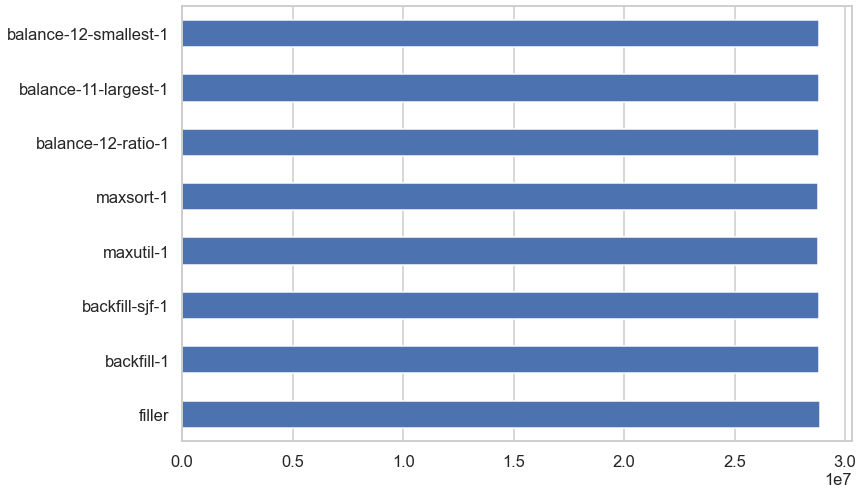

In [85]:
ax = metrics['makespan'].plot.barh(figsize=(12, 8))
ax.grid(axis='y')

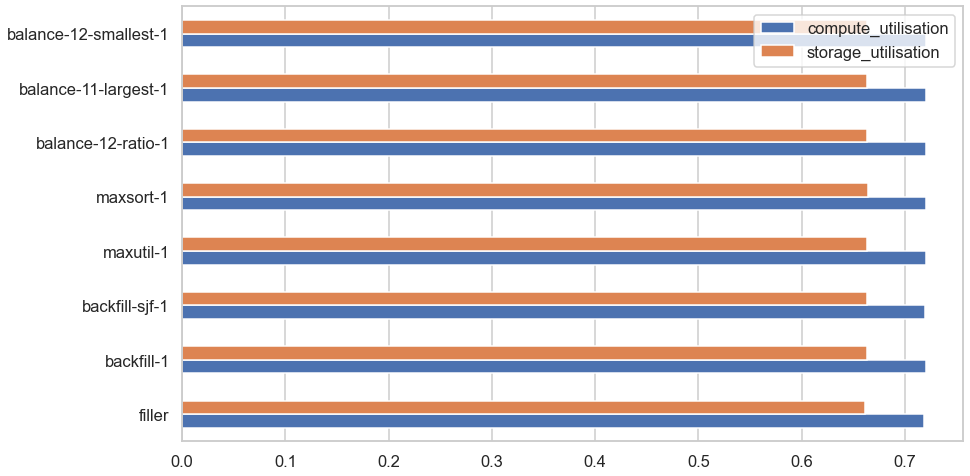

In [86]:
ax = metrics[['compute_utilisation', 'storage_utilisation']].plot.barh(figsize=(14, 8))
ax.grid(axis='y')

In [87]:
waiting_times = create_metric_df('waiting_time')
waiting_times.describe()

,filler,backfill-1,backfill-sjf-1,maxutil-1,maxsort-1,balance-12-ratio-1,balance-11-largest-1,balance-12-smallest-1
count,2.845300e+04,28453.000000,28453.000000,28453.000000,28453.000000,28453.000000,28453.000000,28453.000000
mean,2.125873e+04,14554.136424,13917.227718,26825.496423,27760.806005,13833.674809,14028.049805,14217.327237
std,1.508317e+05,40463.245257,42628.488380,68250.241212,61140.641743,42557.378235,42085.263298,44303.431750
min,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000e+00,82.648256,0.000000,2103.000000,3072.422335,0.000000,5.847458,0.000000
75%,5.005819e+03,9469.730070,6470.368973,18982.253323,25380.167511,6678.107605,7940.000000,6176.301827
max,4.991701e+06,639435.911771,634988.117097,694216.506452,658480.226756,589357.183284,678636.304014,631015.303533


(0.0, 1000000.0)

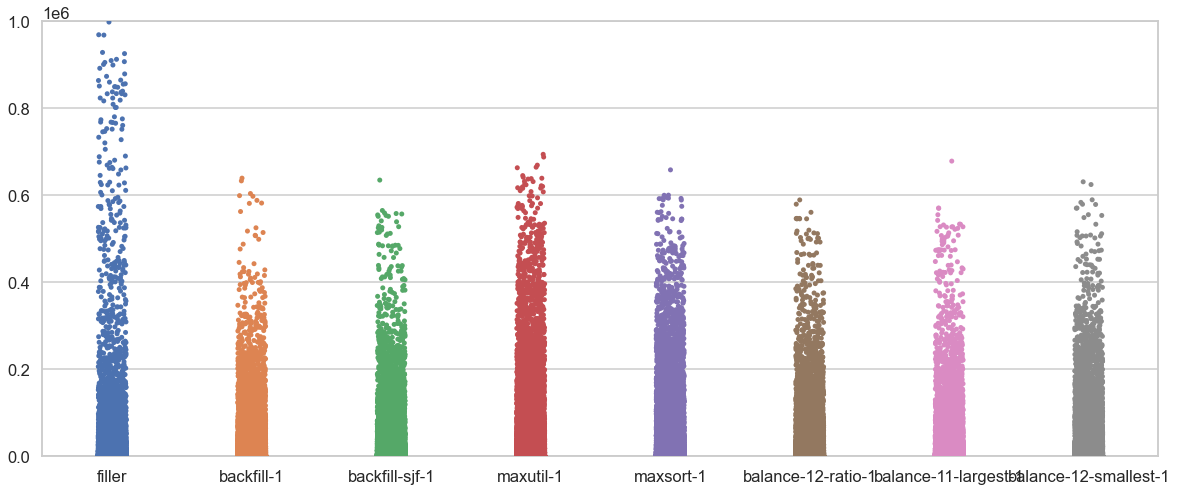

In [88]:
# Scatterplot, outliers
fig, ax = plt.subplots(figsize=(20,8))
sns.stripplot(data=waiting_times, ax=ax)
ax.set_ylim(0, 10**6)

<AxesSubplot:>

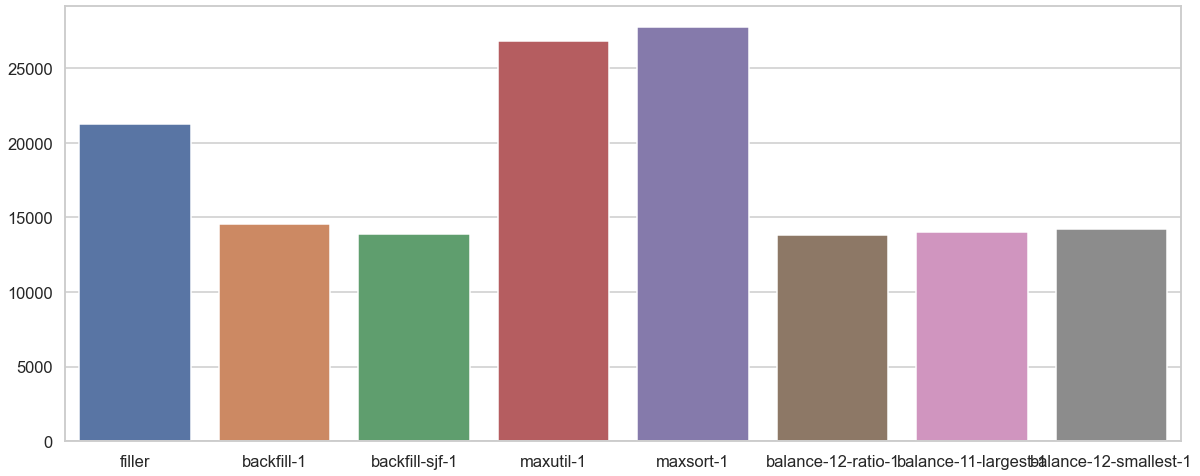

In [89]:
# Mean, logscale
fig, ax = plt.subplots(figsize=(20,8))
sns.barplot(data=waiting_times, ci=None, ax=ax)

<AxesSubplot:>

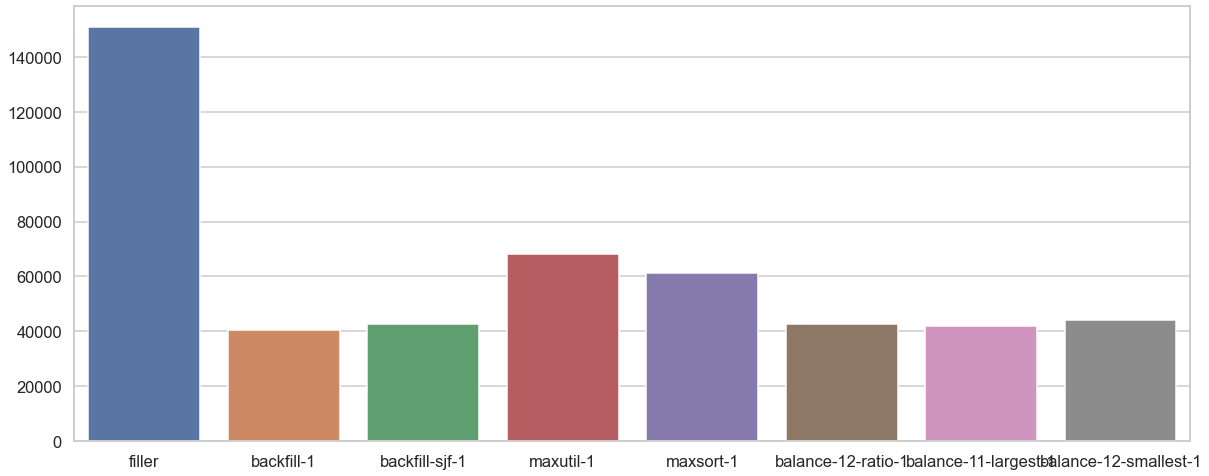

In [90]:
# Mean, logscale
fig, ax = plt.subplots(figsize=(20,8))
sns.barplot(data=waiting_times, estimator=np.std, ci=None, ax=ax)

(0.0, 66618.73507800177)

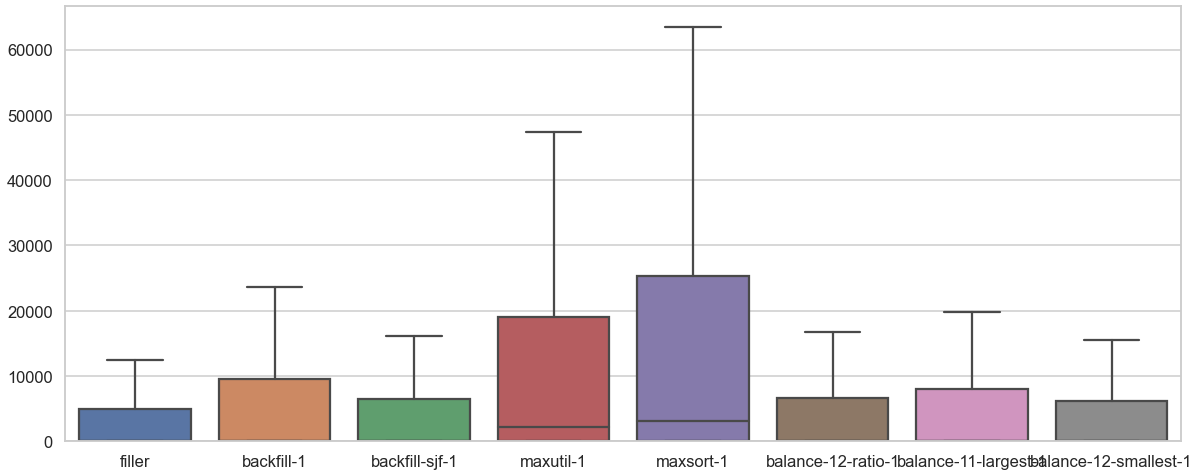

In [91]:
# Standard deviation
fig, ax = plt.subplots(figsize=(20,8))
sns.boxplot(data=waiting_times, showfliers=False, ax=ax)
ax.set_ylim(0)

In [92]:
turnaround_times = create_metric_df('turnaround_time')
turnaround_times.describe()

,filler,backfill-1,backfill-sjf-1,maxutil-1,maxsort-1,balance-12-ratio-1,balance-11-largest-1,balance-12-smallest-1
count,2.845300e+04,28453.000000,28453.000000,28453.000000,28453.000000,28453.000000,28453.000000,28453.000000
mean,3.004135e+04,23338.310470,22701.429423,35611.570141,36546.731080,22618.116884,22812.516620,23001.669760
std,1.523364e+05,47638.147605,49955.852757,73028.466967,65797.303996,49323.795108,49197.487366,50912.489109
min,9.040000e-02,0.166378,0.196674,0.127128,0.125148,0.125148,0.090400,0.090400
25%,1.690134e+02,228.354229,127.322207,894.845399,1267.603748,124.147228,164.816224,133.559787
50%,5.318302e+03,6193.432889,4589.274884,9864.159545,11779.899546,4848.883286,5502.186556,4826.629558
75%,2.069844e+04,23883.842587,20597.501239,35672.940927,41820.441872,21572.621313,22479.919508,20590.235199
max,5.000808e+06,676610.196004,645513.341760,731399.767722,669005.381307,590088.158670,689161.682135,668176.298285


(0.0, 1000000.0)

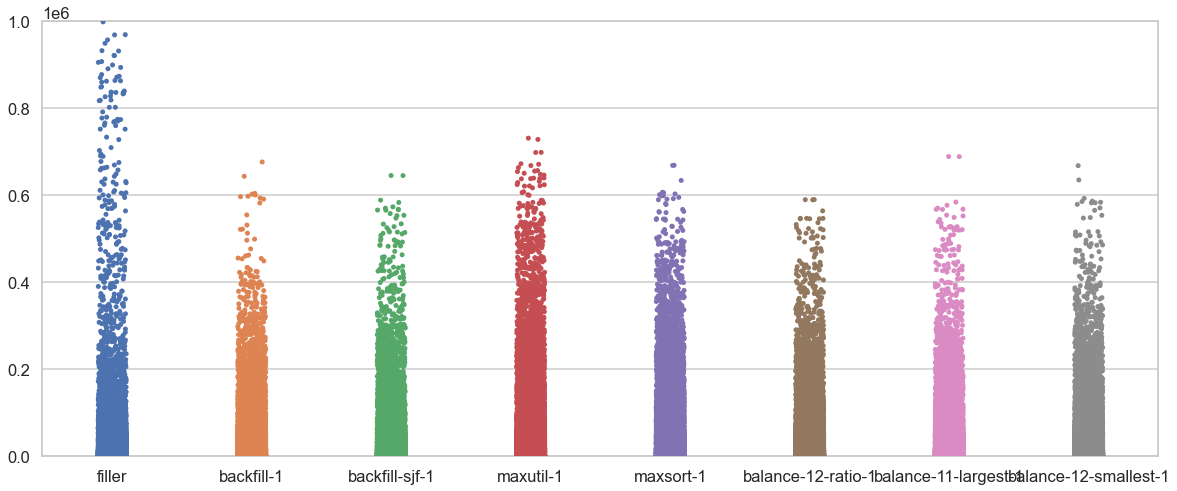

In [93]:
# Scatterplot, outliers
fig, ax = plt.subplots(figsize=(20,8))
sns.stripplot(data=turnaround_times, ax=ax)
ax.set_ylim(0,10**6)

<AxesSubplot:>

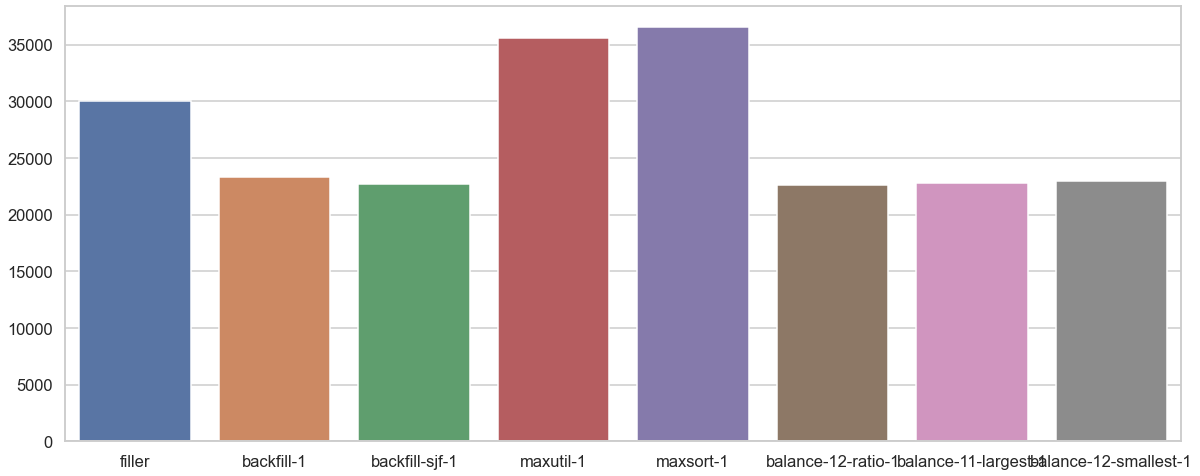

In [94]:
# Mean, logscale
fig, ax = plt.subplots(figsize=(20,8))
sns.barplot(data=turnaround_times, ci=None, ax=ax)

<AxesSubplot:>

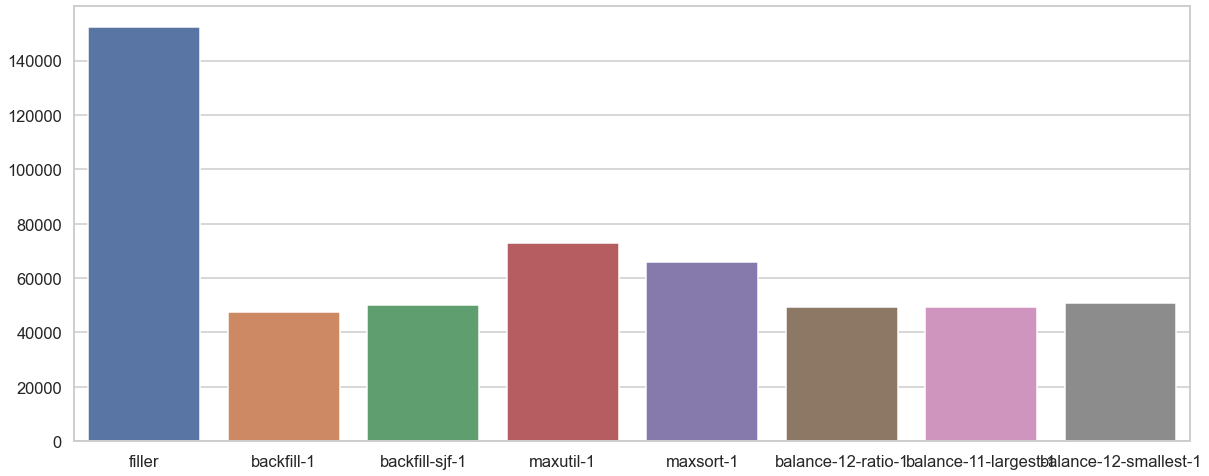

In [95]:
# Mean, logscale
fig, ax = plt.subplots(figsize=(20,8))
sns.barplot(data=turnaround_times, estimator=np.std, ci=None, ax=ax)

(0.0, 107766.36125350166)

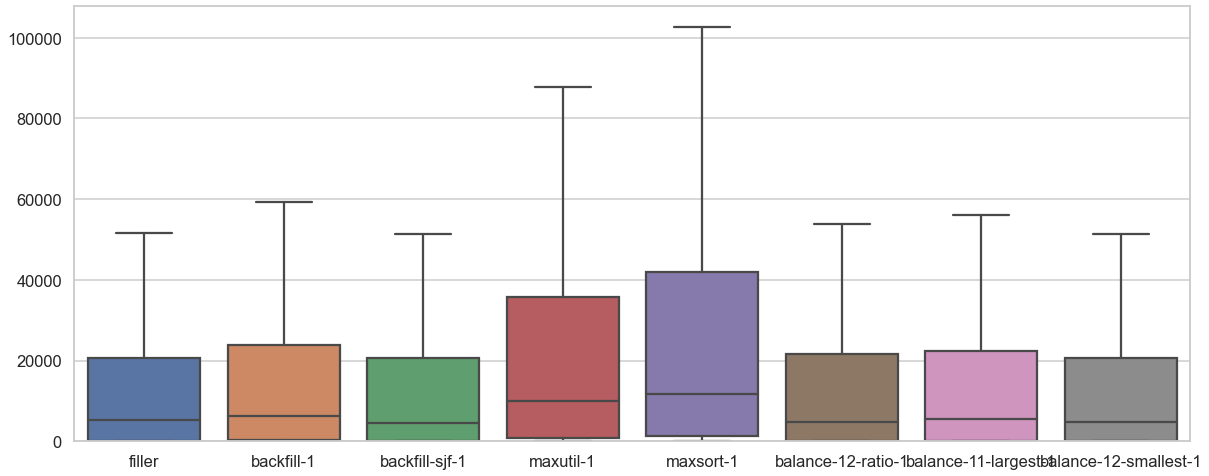

In [96]:
# Standard deviation
fig, ax = plt.subplots(figsize=(20,8))
sns.boxplot(data=turnaround_times, showfliers=False, ax=ax)
ax.set_ylim(0)

In [97]:
slowdown = create_metric_df('stretch')
slowdown.describe()

,filler,backfill-1,backfill-sjf-1,maxutil-1,maxsort-1,balance-12-ratio-1,balance-11-largest-1,balance-12-smallest-1
count,28453.000000,28453.000000,28453.000000,2.845300e+04,28453.000000,28453.000000,28453.000000,28453.000000
mean,180.639638,177.151205,129.122620,4.788925e+02,659.024428,146.848442,178.400861,139.625944
std,1026.405021,1101.823154,951.051236,7.531804e+03,4370.937417,1067.831730,1385.622668,857.211919
min,1.000000,1.000000,1.000000,1.000000e+00,1.000000,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000,1.000000e+00,1.000000,1.000000,1.000000,1.000000
50%,1.000000,1.044776,1.000000,1.874812e+00,2.098685,1.000000,1.005077,1.000000
75%,5.232060,7.975179,4.761832,4.060380e+01,59.495720,4.686927,5.951358,4.742767
max,42459.521527,83237.330498,91699.288052,1.178247e+06,292047.794373,104436.175020,126388.257814,38076.791776


(0.0, 200000.0)

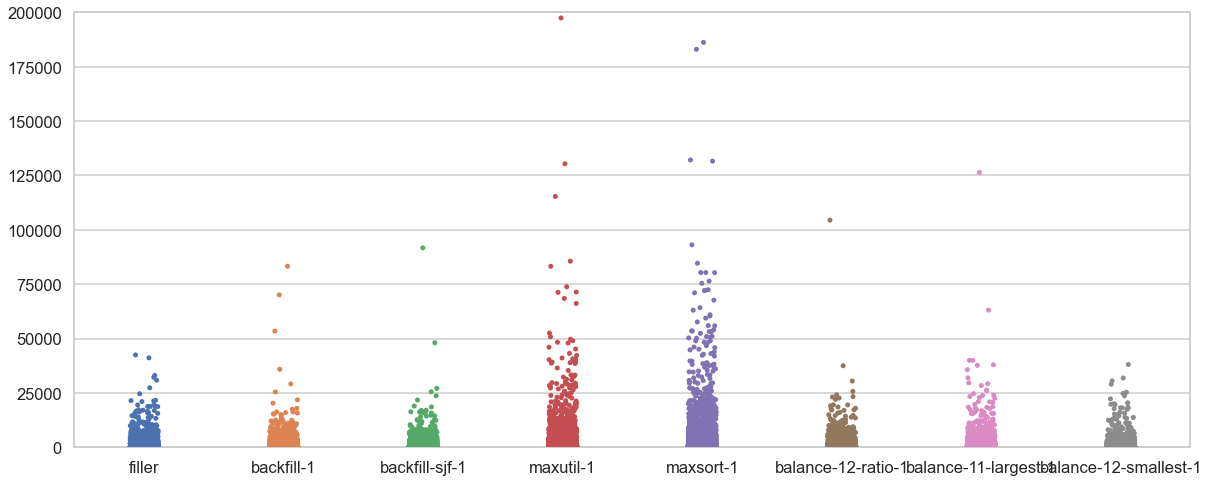

In [98]:
# Scatterplot, outliers
fig, ax = plt.subplots(figsize=(20,8))
sns.stripplot(data=slowdown, ax=ax)
ax.set_ylim(0, 0.2*10**6)

<AxesSubplot:>

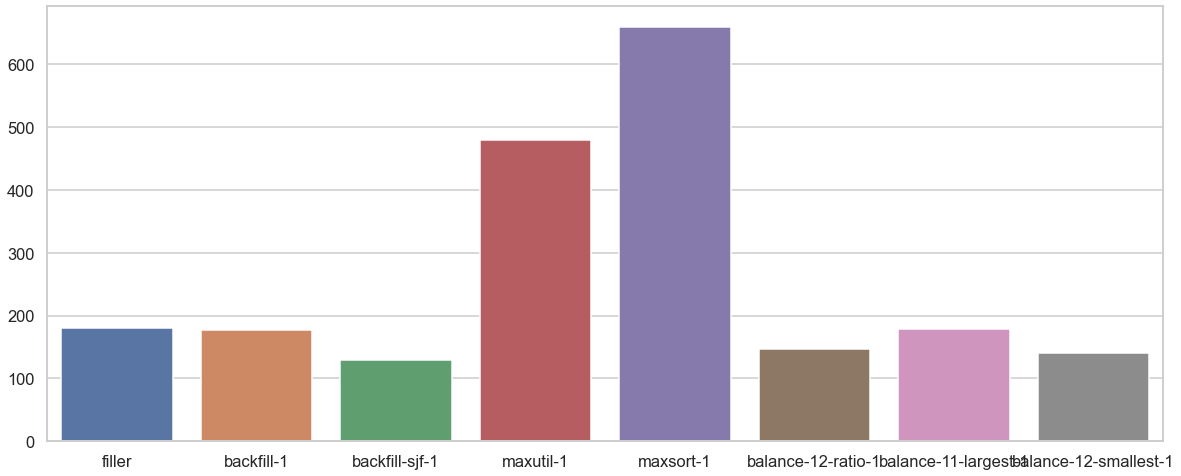

In [99]:
# Mean, logscale
fig, ax = plt.subplots(figsize=(20,8))
sns.barplot(data=slowdown, ci=None, ax=ax)

<AxesSubplot:>

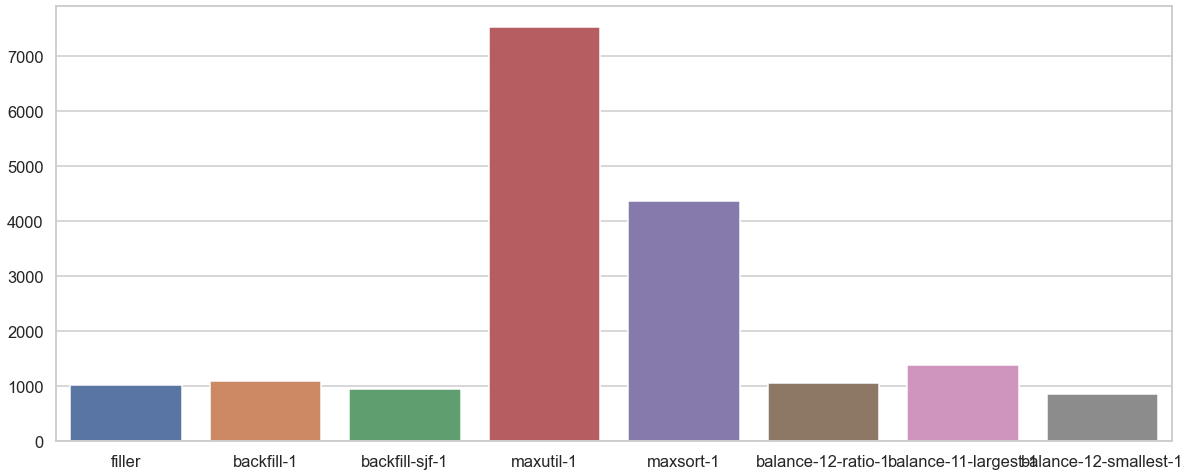

In [100]:
# Mean, logscale
fig, ax = plt.subplots(figsize=(20,8))
sns.barplot(data=slowdown, estimator=np.std, ci=None, ax=ax)

(0.0, 154.53577003331495)

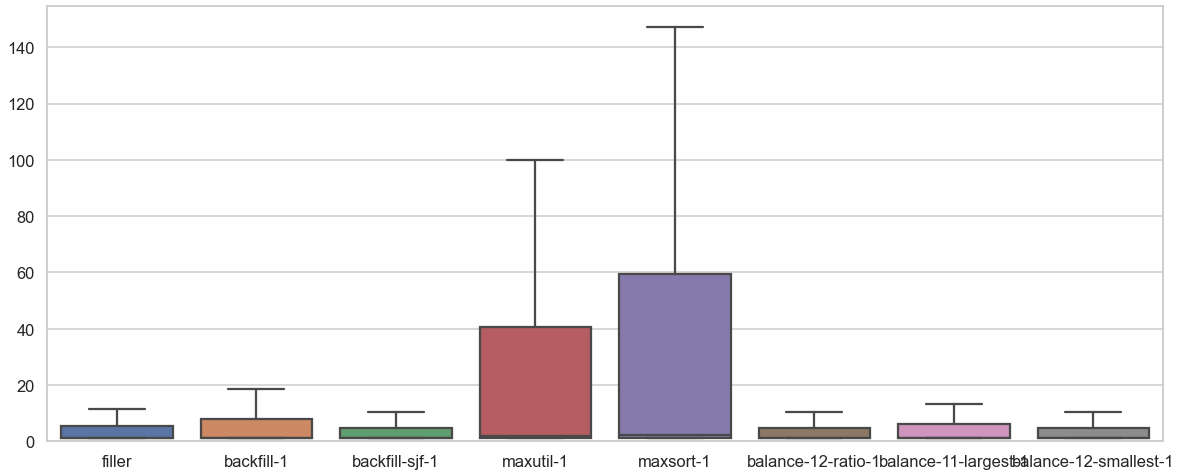

In [101]:
# Standard deviation
fig, ax = plt.subplots(figsize=(20,8))
sns.boxplot(data=slowdown, showfliers=False, ax=ax)
ax.set_ylim(0)

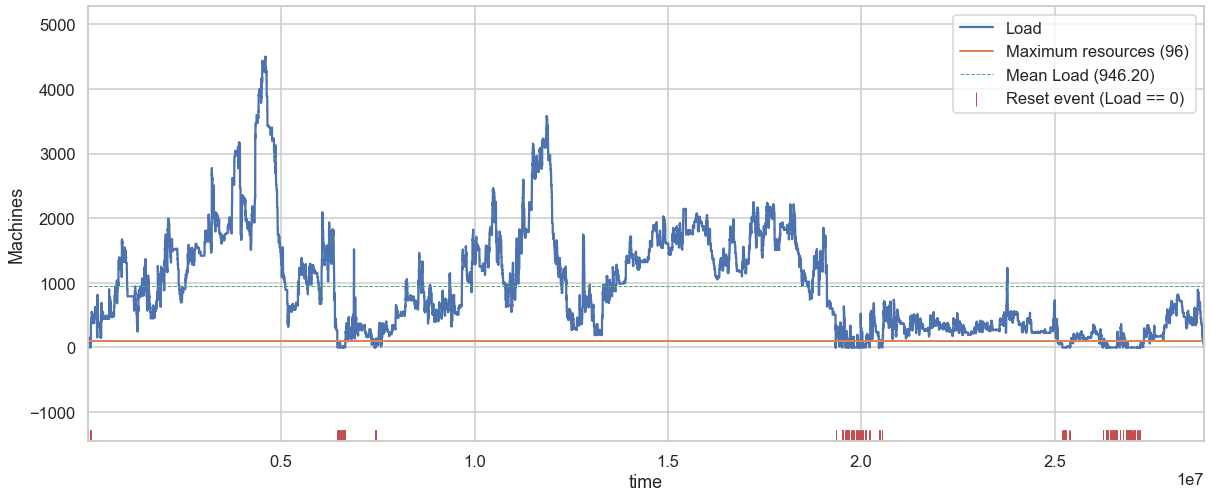

In [75]:
fig, ax = plt.subplots(figsize=(20,8))
visu.legacy.plot_load(jobsets['filler'].queue, nb_resources=96, ax=ax)

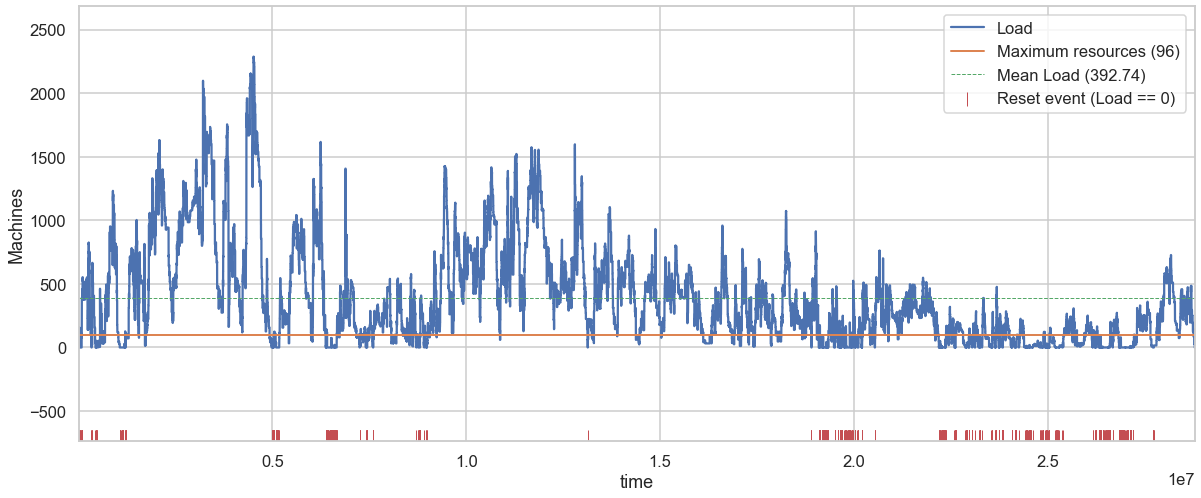

In [76]:
fig, ax = plt.subplots(figsize=(20,8))
visu.legacy.plot_load(jobsets['backfill-1'].queue, nb_resources=96, ax=ax)

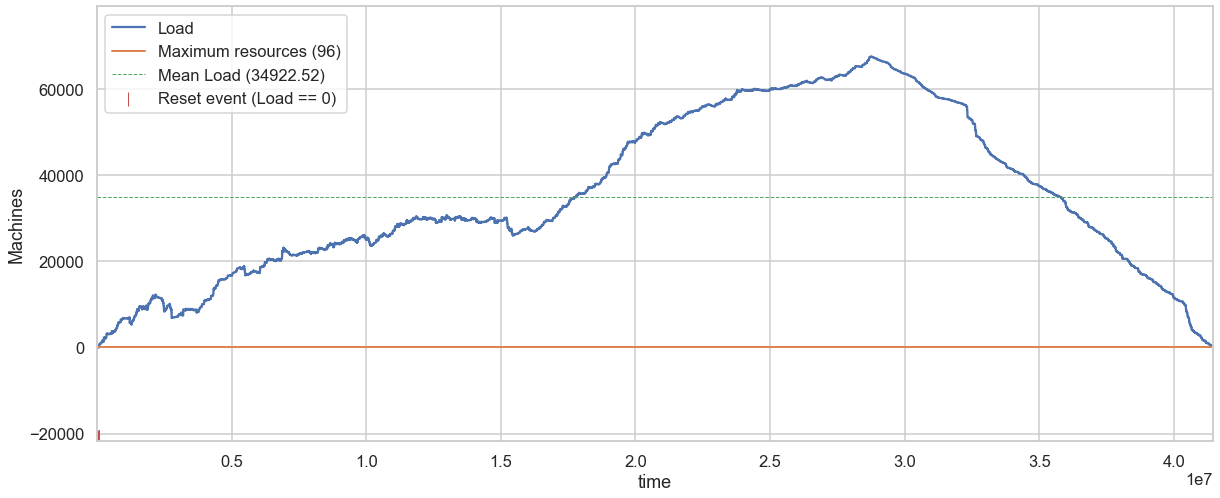

In [77]:
fig, ax = plt.subplots(figsize=(20,8))
visu.legacy.plot_load(jobsets['no-reserve-1'].queue, nb_resources=96, ax=ax)

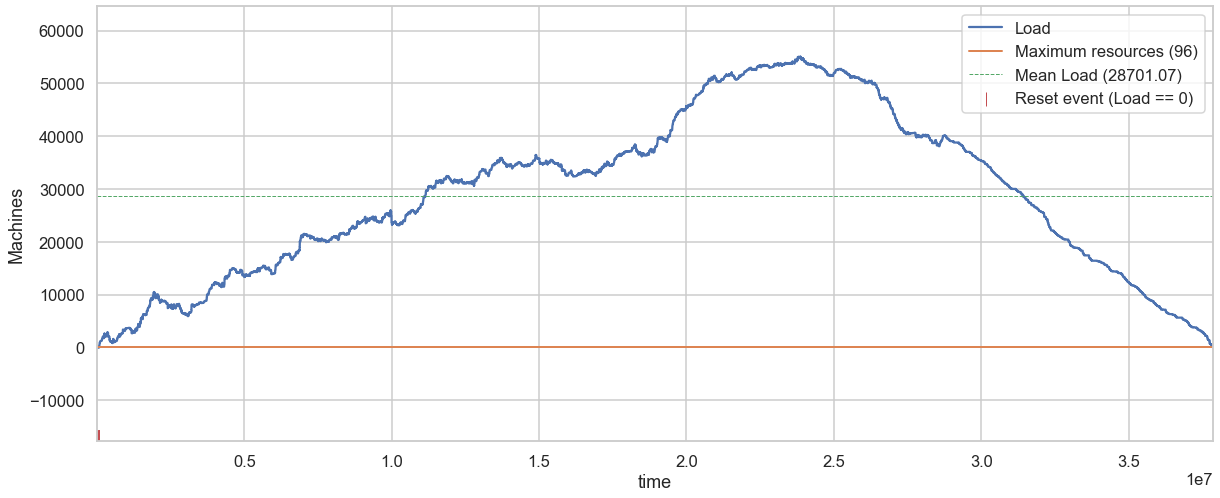

In [78]:
fig, ax = plt.subplots(figsize=(20,8))
visu.legacy.plot_load(jobsets['fcfs'].queue, nb_resources=96, ax=ax)